<h1> Making an predictive model using Gradient Boosting Machine</h1>
In deze jupyter notebook file, worden de de decision tree gemaakt. 
Dit wordt gedaan om de onderzoeksvraag van mijn thesis te kunnen beantwoorden:
To what extent can support vector machine, randomforest tree, or Gradient Boosting Machine contributeto predicting the demand for the specialist youth caresegments in Amsterdam?
Ook is dit nodig voor het beantwoorden van mijn sub vraen:
•Are there neighborhood socio-demographic characteristics which are predictive of the use of youth caresegments?
•Which of the tested models has the highest f1 score in predicting the youth care segment use?


<h3>Hier onder worden eerst de benodigde librabry geimporteerd</h3>

In [1]:
import pandas as pd
import xgboost
import time
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pyplot

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from numpy import mean
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import plot_importance

from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

Om de sub onderzoeks vraag: Which of the tested models has the highest f1-score in predicting the youth care segment use? Waarom we voor deze score hebben gekozen, kan gelezen worden onder het kopje "model eveluation".

Ook maken we een aantal variabele hier aan om de code zo gestructuurd mogelijk te houden. Waarom deze nodig zijn, valt te lezen in het kopje "model making'

In [2]:
# define some variables
param_grid = {
        'max_depth': range(4,26,4),
        'scale_pos_weight' : [1, 25, 50, 75, 100],
        'colsample_bytree': np.arange(0.5,1.0,0.3),
}


cv_method = RepeatedStratifiedKFold(n_splits=2, 
                                    n_repeats=1, 
                                    random_state=42)

def calculateMetrics(model):
        y_predicted = model.predict(X_test)
        print(model)
        print ("F1 score")
        print(f1_score(y_test, y_predicted, average='micro'))

<h3> Laad de data in, die gemaakt is uit de andere jupyter notebook file</h3

In [3]:
df = pd.read_pickle("C:\\VERTROUWELIJK\\final_dataSet.pkl")

Split the data in indepentend variable an dependent variable. 

In [4]:
X = df.drop(['Voorziening'], axis=1)
X_encoded = pd.get_dummies(X, columns=['Geslacht'])
y = df['Voorziening'].copy()

encode string class values as integers, which is needed for Gradient Boosting

In [5]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

Make train and test set. Waarom dit nodig is, zie "making model" 

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_encoded, label_encoded_y)

<h3>Make the first gradient Boosting</h3>
and fit this to get the scores. Dit is nodig om alle onderzoeksvragen mee te bentwoorden.
Zie "model" in de thesis waarom we voro xgboost hebben gekozen en niet noor de standaard aangeleverde vanuit sklearn

In [7]:
# fit model no training data
model = xgboost.XGBClassifier()
start_time=time.time()
# model.fit(X_train, y_train)
print(model)
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_micro')
score = mean(scores)
print("f1_score: %.2f%%" % (score * 100.0))
std_scores = scores.std()
print("f1_score STD")
print(std_scores)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
f1_score: 60.72%
f1_score STD
0.01406216108225521


Zoals gezegd, de data is erg imbalanced. Daarom maken we een decision tree with random undersampling

In [8]:
steps = [('under', RandomUnderSampler()), ('model', xgboost.XGBClassifier())]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=42)
scores = cross_val_score(pipeline, X_encoded, label_encoded_y, scoring='f1_micro', cv=cv, n_jobs=-1, verbose = 10)
score = mean(scores)
print('F1 Score: %.3f' % score)
std_scores = scores.std()
print("f1_score STD")
print(std_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


F1 Score: 0.237
f1_score STD
0.006137865911236995


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   41.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   41.5s finished


<h3>Prune the model</h3>
Na het vergelijken van de twee modellen, heeft het model met de normale data set de hoogste F1 score, hier na gaan we het model nog prunen. Zie Making Model in de thesis

In [9]:
# make an gridSearch
start_time=time.time()
grid = GridSearchCV(xgboost.XGBClassifier(),
                   param_grid=param_grid,
                    scoring='f1_micro',
                   verbose=10,
                    cv= cv_method,
                   n_jobs=-1)
start_time=time.time()

grid.fit(X_train,y_train)
print(time.time()-start_time)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 36.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done 118 out of 120 | elapsed: 76.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 77.4min finished


[14:19:48] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


4694.308219432831


Getting the scores of the GridSearch

In [10]:
grid.cv_results_['std_test_score'][grid.best_index_]

0.008775807200974262

In [11]:
# get the best parameters of coming from the gridSearch.
grid.best_params_

{'colsample_bytree': 0.8, 'max_depth': 4, 'scale_pos_weight': 1}

In [12]:
# get the best F1 score, coming from the gridSearch.
grid.best_score_

0.5782002676326289

Om de onderzoeks vraag: Are there neighborhood socio-demographic characteristics which are predictive of the use of youth caresegments? is onderstaande code nodig om een plot te maken voor in het model. Eerst maken we weer het eerder genoemde basis model, om zo de figuren te kunnen maken.

In [13]:
XGboost =  xgboost.XGBClassifier()
XGboost = XGboost.fit(X_train, y_train)

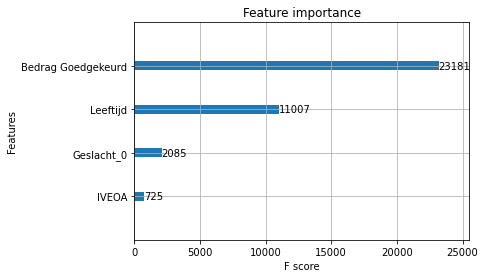

In [14]:
# Plot the top 4 most important features of the XGboost model
ax = xgboost.plot_importance(XGboost,max_num_features=4)
ax.figure.savefig('feature Importance.png')

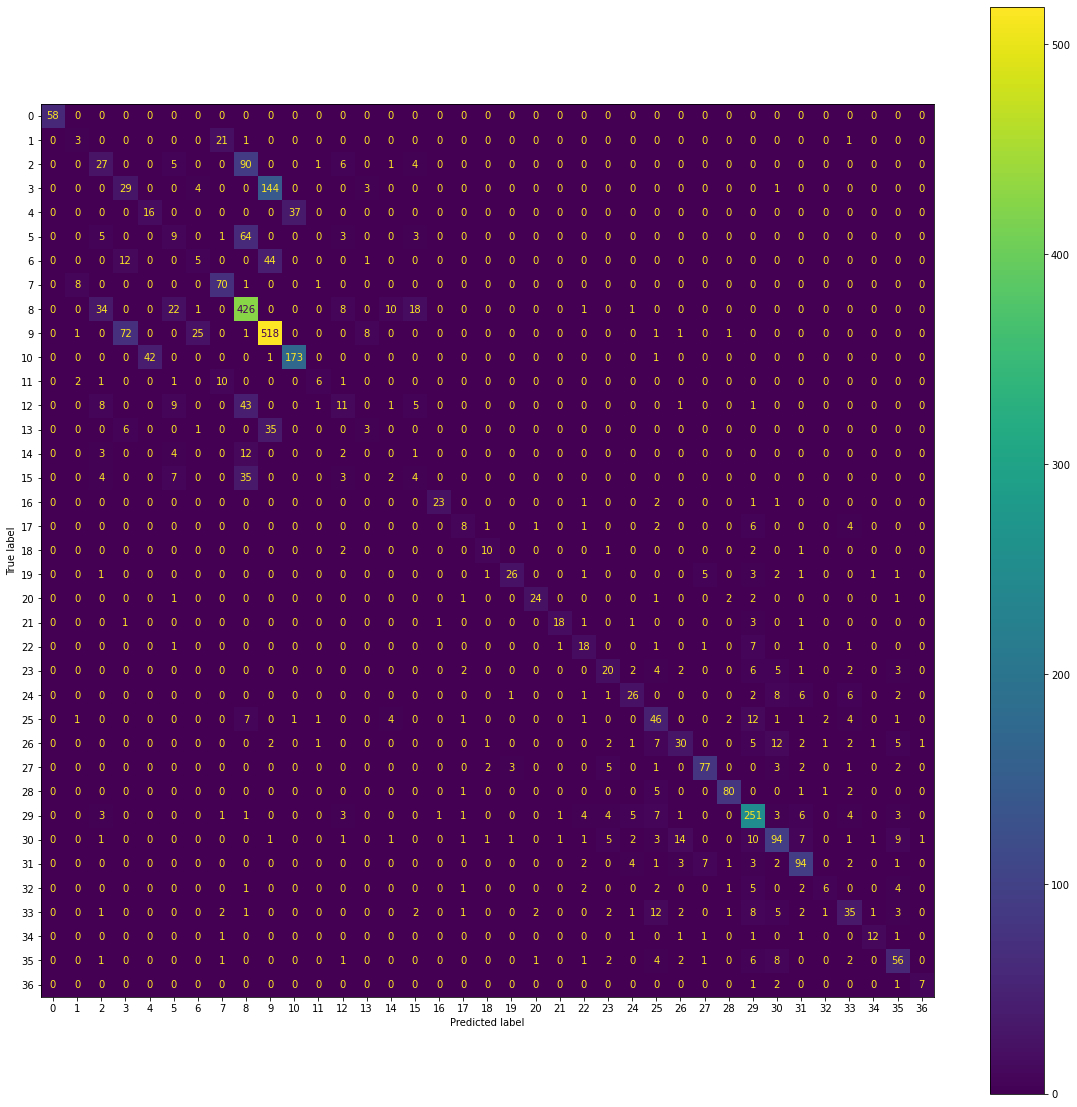

In [15]:
# Create an Confusion Matrix to get an insight of how well the model is performing. 
fig, ax = plt.subplots(figsize=(20,20))
plot_confusion_matrix(XGboost, X_test, y_test, ax=ax)
fig.savefig('confusion_matrix_XGBoost.png')

See part "Results"
After seeing the results, we can see that "bedrag goedgekeurd" has a very high level of importance. Beceasue this variable is generated by our self, we wanted to investigate more in order to see what the overall performance is on the whole model.
For doing this, we needed to re-load the data, an make an new model with this data.

In [16]:
X_bedrag = df.drop(['Voorziening','Bedrag Goedgekeurd'], axis=1)
X_encoded_bedrag = pd.get_dummies(X_bedrag, columns=['Geslacht'])
y = df['Voorziening'].copy()

In [17]:
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
label_encoded_y = label_encoder.transform(y)

In [18]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_encoded_bedrag, label_encoded_y)

In [19]:
XGboost =  xgboost.XGBClassifier()
XGboost = XGboost.fit(X_train, y_train)
calculateMetrics(XGboost)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
F1 score
0.1613164283787429


Get the Standard deviadtion of the Bedrag Goedgekeurd grouped by the Voorzieningen. In combinaten with the mean, we can check if one voorziening is straitforward for one "bedrag goedgekeurd" 

In [20]:
df.groupby('Voorziening')['Bedrag Goedgekeurd'].std()

Voorziening
B1I       317.631097
B2DL      818.719638
B2DZ     2088.617236
B2I       715.421098
B2P       371.529585
B4DZ     2092.277222
B4I       693.353328
B5DL      834.177210
B5DZ     2018.073992
B5I       751.905370
B5P       357.158092
B6DL      834.757311
B6DZ     2154.418388
B6I       576.558593
B7DZ     2056.925021
B8DZ     2058.031823
C1I      3137.275115
C2DL     4290.179241
C2DZ    10213.853657
C2I     13373.061503
C2P      4580.406821
C3DZ     9297.084564
C4DL     9098.738260
C4DZ    26213.908758
C4I     11799.708726
C5DL     5108.192677
C5DZ    23286.130306
C5I     12865.395794
C5P      3557.108408
C6DL     5603.575869
C6DZ    37690.334902
C6I     12963.295223
C6P      7746.220764
C8DL    13211.959976
C8DM    12448.750883
C8DZ    27138.426332
C8I     19002.308857
Name: Bedrag Goedgekeurd, dtype: float64

In [21]:
df.groupby('Voorziening')['Bedrag Goedgekeurd'].mean()

Voorziening
B1I       761.192893
B2DL     1376.797788
B2DZ     3823.370066
B2I      2348.698264
B2P      1138.636364
B4DZ     3921.966927
B4I      2308.186620
B5DL     1451.977027
B5DZ     3674.094590
B5I      2484.005857
B5P      1199.970203
B6DL     2001.494667
B6DZ     3611.163262
B6I      2470.000000
B7DZ     4342.518193
B8DZ     4438.219298
C1I      7566.890411
C2DL     9375.273299
C2DZ    19800.232558
C2I     22535.490196
C2P      9476.589744
C3DZ    18884.445312
C4DL    16373.138786
C4DZ    33702.238095
C4I     19376.135516
C5DL     8332.396739
C5DZ    23553.266762
C5I     25267.747041
C5P      9309.605672
C6DL    13981.283178
C6DZ    44979.923481
C6I     23125.938304
C6P     11425.098214
C8DL    15653.104694
C8DM    24562.558824
C8DZ    42699.052560
C8I     37134.180556
Name: Bedrag Goedgekeurd, dtype: float64

For visulating the four highest freq of voorzieningen, we need the following code.

In [22]:
df['Voorziening'].value_counts().nlargest(4)

B5I     2561
B5DZ    2161
C6DL    1136
B5P      839
Name: Voorziening, dtype: int64

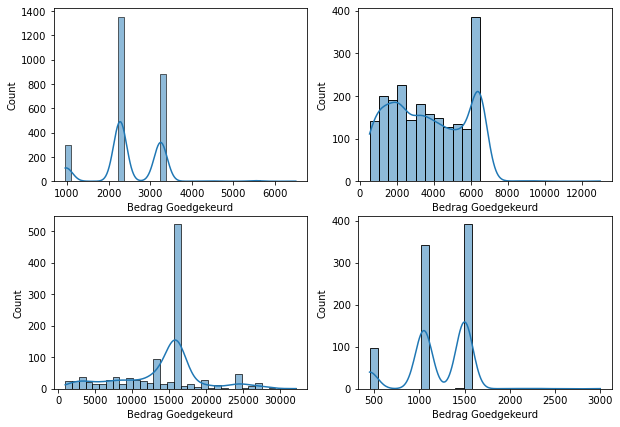

In [23]:
fig = plt.figure()
fig.set_figheight(7)
fig.set_figwidth(10)

ax = fig.add_subplot(2, 2, 1)
sns.histplot(df[df['Voorziening'] == 'B5I']['Bedrag Goedgekeurd'], ax=ax, kde=True)
ax = fig.add_subplot(2, 2, 2)
sns.histplot(df[df['Voorziening'] == 'B5DZ']['Bedrag Goedgekeurd'],ax=ax, kde=True)
ax = fig.add_subplot(2, 2, 3)
sns.histplot(df[df['Voorziening'] == 'C6DL']['Bedrag Goedgekeurd'],ax=ax,kde=True)
ax = fig.add_subplot(2, 2, 4)
sns.histplot(df[df['Voorziening'] == 'B5P']['Bedrag Goedgekeurd'],ax=ax,kde=True)
fig.savefig('overview for voorzieningen distplot.png')

To see the "new" feature importance, we created this new fig. 

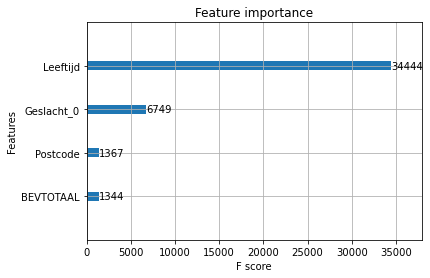

In [24]:
ax = xgboost.plot_importance(XGboost,max_num_features=4)
ax.figure.savefig('feature Importance removed Bedrag.png')